# Dimensionality reduction with T-SNE


In [46]:
import os
import sys
import numpy as np
import sklearn
import keras as K
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import kaggle
from numba import cuda
import t_sne_bhcuda.t_sne_bhcuda.bhtsne_cuda as tsne_bhcuda
from utils import (plot_tsne, get_gpu_name, get_cuda_version, get_cudnn_version,
                   find_files_with_pattern, featurize_images)

print("System version: {}".format(sys.version))
print("Sklearn version: {}".format(sklearn.__version__))
print("Numpy version: {}".format(np.__version__))
print("Kaggle version: {}".format(kaggle.KaggleApi.__version__))
print("Keras version: {}".format(K.__version__))
print("Keras backend: {}".format(K.backend.backend()))
print("Keras image data format: {}".format(K.backend.image_data_format()))
print("Tensorflow version: {}".format(tf.__version__))
print("GPU: {}".format(get_gpu_name()))
print("CUDA version: {}".format(get_cuda_version()))
print("CuDNN version: {}".format(get_cudnn_version()))

%load_ext autoreload
%autoreload 2

System version: 3.5.5 |Anaconda custom (64-bit)| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]
Sklearn version: 0.19.1
Numpy version: 1.14.5
Kaggle version: 1.5.0
Keras version: 2.2.2
Keras backend: tensorflow
Keras image data format: channels_last
Tensorflow version: 1.10.1
GPU: ['Tesla K80']
CUDA version: CUDA Version 9.2.148
CuDNN version: 7.2.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset

[Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset, which contains 2 classes and 25000 images.

Make sure you follow the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get the Kaggle credentials. 


In [3]:
!/anaconda/envs/py35/bin/kaggle competitions download -c dogs-vs-cats --force

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 2.08MB/s]
 94%|██████████████████████████████████████▋  | 256M/271M [00:01<00:00, 159MB/s]
100%|████████████████████████████████████████| 271M/271M [00:04<00:00, 58.7MB/s]
 98%|████████████████████████████████████████▏| 533M/543M [00:03<00:00, 166MB/s]
100%|████████████████████████████████████████| 543M/543M [00:07<00:00, 74.5MB/s]


In [4]:
!unzip -q train.zip

In [7]:
files_dog = find_files_with_pattern("train", "dog*")
files_dog = files_dog[:1000]
print(len(files_dog))

files_cat = find_files_with_pattern("train", "cat*")
files_cat = files_cat[:1000]
print(len(files_cat))

file_names = files_dog + files_cat

1000
1000


In [8]:
labels_dog = [0]*len(files_dog)
labels_cat = [1]*len(files_cat)
labels = labels_dog + labels_cat
print(len(labels))

2000


### Image featurization

In [9]:
#https://keras.io/applications/#resnet50
model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

In [10]:
features = featurize_images(file_names, model)
print(features.shape)

32it [00:23,  1.57it/s]

(2000, 2048)


In [42]:
# clear gpu memory
cuda.select_device(0)
cuda.close()

### Dimensionality reduction with TSNE

In [43]:
perplexity = 10.0
theta = 0.5
learning_rate = 200.0
iterations = 2000
gpu_mem = 0.8
files_dir='tsne_results'

In [12]:
%%time
t_sne_result_sklearn = tsne_bhcuda.t_sne(samples=features, use_scikit=True, files_dir=files_dir,
                        no_dims=2, perplexity=perplexity, eta=learning_rate, theta=theta,
                        iterations=iterations, gpu_mem=gpu_mem, randseed=-1, verbose=2)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.137s...
[t-SNE] Computed neighbors for 2000 samples in 16.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 13.394749
[t-SNE] Computed conditional probabilities in 0.159s
[t-SNE] Iteration 50: error = 22.1997929, gradient norm = 0.0175230 (50 iterations in 1.919s)
[t-SNE] Iteration 100: error = 21.9945698, gradient norm = 0.0100841 (50 iterations in 1.455s)
[t-SNE] Iteration 150: error = 21.9797535, gradient norm = 0.0100702 (50 iterations in 1.451s)
[t-SNE] Iteration 200: error = 21.9771709, gradient norm = 0.0100735 (50 iterations in 1.465s)
[t-SNE] Iteration 250: error = 21.9760437, gradient norm = 0.0100741 (50 iterations in 1.484s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 21.976044
[t-SNE] Iteration 300: error = 1.9844135, gradient norm = 0.0053701 (50 iterations in 1.437

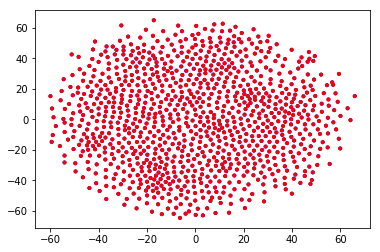

In [21]:
plot_tsne(t_sne_result_sklearn, labels)

In [47]:
%%time
t_sne_result_gpu = tsne_bhcuda.t_sne(samples=features, use_scikit=False, files_dir=files_dir,
                        no_dims=2, perplexity=perplexity, eta=learning_rate, theta=theta,
                        iterations=iterations, gpu_mem=gpu_mem, randseed=-1, verbose=2)

Read the 2000 x 2048 data matrix successfully!
Using current time as random seed...
Using no_dims = 2, perplexity = 10.000000, learning rate = 200.000000, and theta = 0.500000
Computing input similarities...

Device Name = Tesla K80
multiProcessorCount: 13
totalGlobalMem (in MB): 11441.187500
totalGlobalMem (in GB): 11.173035
sharedMemPerBlock (in bytes): 49152
Maximum number of threads per block: 1024
Maximum size of each dimension of a block: 1024 x 1024 x 64
Maximum sizes of each dimension of a grid: 2147483647 x 65535 x 65535
Compute capability of the device = 3.7
canMapHostMemory: TRUE
deviceOverlap: TRUE
GPU memory usage: used = 71.000000 MB, free = 11370.187500 MB, total = 11441.187500 MB

GPU iteration = 0, distance elements calculated = 4000000
GPU memory usage: used = 117.625000 MB, free = 11323.562500 MB, total = 11441.187500 MB
Time spent in calculating all distances in GPU: 0.515097
Building tree...
 - Building tree and finding perplexities, point 0 of 2000
Time spent buil

In [ ]:
plot_tsne(t_sne_result_gpu, labels)

In [51]:
!rm -rf train